In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import os
import shutil

In [10]:
# define hyperparameters
N_EPOCHS = 10
BATCH_SIZE = 5
LEARNING_RATE = 0.01

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # n, 3, 32, 32
        x = self.pool(functional.relu(self.conv1(x))) # n, 6, 14, 14
        x = self.pool(functional.relu(self.conv2(x))) # n, 16, 5, 5
        x = x.view(-1, 16*5*5) # n, 400
        x = functional.relu(self.fc1(x)) # n, 120
        x = functional.relu(self.fc2(x)) # n, 84
        x = self.fc3(x) # n, 10
        return x


In [12]:
def get_data():
    # dataset has PILImage images of range [0, 1]
    # transform them to Tensors of normalized range [-1, 1]
    transform = transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.5, 0.5, 0.5), 
                (0.5, 0.5, 0.5)
                )
        ])
        
    # get data with torchvision
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
            './data/', train=True, 
            download=True,
            transform=transform),
        batch_size=BATCH_SIZE, 
        shuffle=True
        )

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
            './data/', train=False, 
            download=True,
            transform=transform),
        batch_size=BATCH_SIZE, 
        shuffle=False
        )

    return train_loader, test_loader

In [13]:
def train(epoch, network, optimizer, loader, losses, counter):
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(loader, 0):
        # no gradients needed
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # show progress
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(
                      epoch, batch_idx * len(data),
                      len(loader.dataset),
                      10. * batch_idx / len(loader),
                      loss.item()
                  )
                  )
            losses.append(loss.item())
            counter.append(
                (batch_idx*10) + ((epoch-1)*len(loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test(network, loader):
    correct_pred = {classname: 0 for classname in CLASSES}
    total_pred = {classname: 0 for classname in CLASSES}
    # again no gradients needed
    with torch.no_grad():
        for (data, targets) in loader:
            outputs = network(data)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for target, prediction in zip(targets, predictions):
                if target == prediction:
                    correct_pred[CLASSES[target]] += 1
                total_pred[CLASSES[target]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))

In [14]:
def visualize(train_counter, train_losses):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

In [15]:
def main():
    train_loader, test_loader = get_data()
    network = MyNet()
    optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE)

    try:
        os.mkdir("results")
    except FileExistsError as err:
        shutil.rmtree("results")
        os.mkdir("results")

    train_losses = []
    train_counter = []

    test(network, test_loader)
    for ep in range(1, N_EPOCHS + 1):
        train(ep, network, optimizer, train_loader, train_losses, train_counter)
        test(network, test_loader)
    
    visualize(train_counter, train_losses)

Files already downloaded and verified
Files already downloaded and verified
Accuracy for class plane is: 1.9 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 80.8 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 13.7 %
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.290707
Train Epoch: 1 [500/50000 (0%)]	Loss: 2.275527
Train Epoch: 1 [1000/50000 (0%)]	Loss: 2.303898
Train Epoch: 1 [1500/50000 (0%)]	Loss: 2.306013
Train Epoch: 1 [2000/50000 (0%)]	Loss: 2.289278
Train Epoch: 1 [2500/50000 (0%)]	Loss: 2.342124
Train Epoch: 1 [3000/50000 (1%)]	Loss: 2.272988
Train Epoch: 1 [3500/50000 (1%)]	Loss: 2.300393
Train Epoch: 1 [4000/50000 (1%)]	Loss: 2.280558
Train Epoch: 1 [4500/50000 (1%)]	Loss: 2.304218
Train Epoch: 1 [5000/50000 (1%)]	Loss: 2.160394
Train Epoch: 1 [5500/50000 (1%)]	Loss: 1.982106


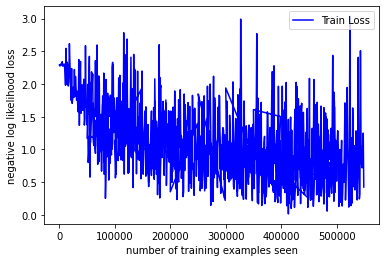

In [16]:
main()